In [1]:
import pandas as pd
import numpy as np
import warnings
import pickle
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helper_functions import *

In [3]:
df = pd.read_csv('../../../Iquitos_train.csv', index_col = 0)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace = True)

In [4]:
df_test = pd.read_csv('../../../dengue_features_test.csv', index_col = 0)
df_test = df_test.loc['iq']
df_test = df_test.set_index('week_start_date')
df_test.index = pd.to_datetime(df_test.index)
df_test.sort_index(inplace = True)

In [5]:
nb_variables = {'window': 4}

In [6]:
print('------ Basic Stats about the Iquitos Training set ------ \n')
print(f'- Number of rows of the training set: {len(df)} \n')
print(f'- Number of columns of the training set: {len(df.columns)}, where the last on is the label \n')
perc = np.round(100 * df.isna().sum().sum() / (len(df) * len(df.columns)), 2)
print(f'- Percentage of missing values across the entire dataset {perc}% \n')
url = 'https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/'
print(f'- Description for all variables can be found here: {url} \n')

------ Basic Stats about the Iquitos Training set ------ 

- Number of rows of the training set: 520 

- Number of columns of the training set: 23, where the last on is the label 

- Percentage of missing values across the entire dataset 1.4% 

- Description for all variables can be found here: https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/ 



In [7]:
df = fill_values(df, nb_variables['window'], give_info = True)
df_test = fill_values(df_test, nb_variables['window'], give_info = True)

Filling NA values with the running mean of 3 previous values (window = 4) 

- The amount of NAs was reduced to 0.11% 

- For the next step we will fill the remaining NAs with zeroes 

Filling NA values with 0 

- The amount of NAs was reduced to 0.0% 

- No more NA values left 

Filling NA values with the running mean of 3 previous values (window = 4) 

- The amount of NAs was reduced to 0.5% 

- For the next step we will fill the remaining NAs with zeroes 

Filling NA values with 0 

- The amount of NAs was reduced to 0.0% 

- No more NA values left 



In [8]:
train_amount = 0.7
cutoff = int(train_amount * len(df))

x = df.drop('total_cases', axis = 1)
y = df['total_cases']

x_train = x.iloc[:cutoff, :]
x_val = x.iloc[cutoff:, :]

y_train = y.iloc[:cutoff]
y_val = y.iloc[cutoff:]

- Check the histograms of the variables. 



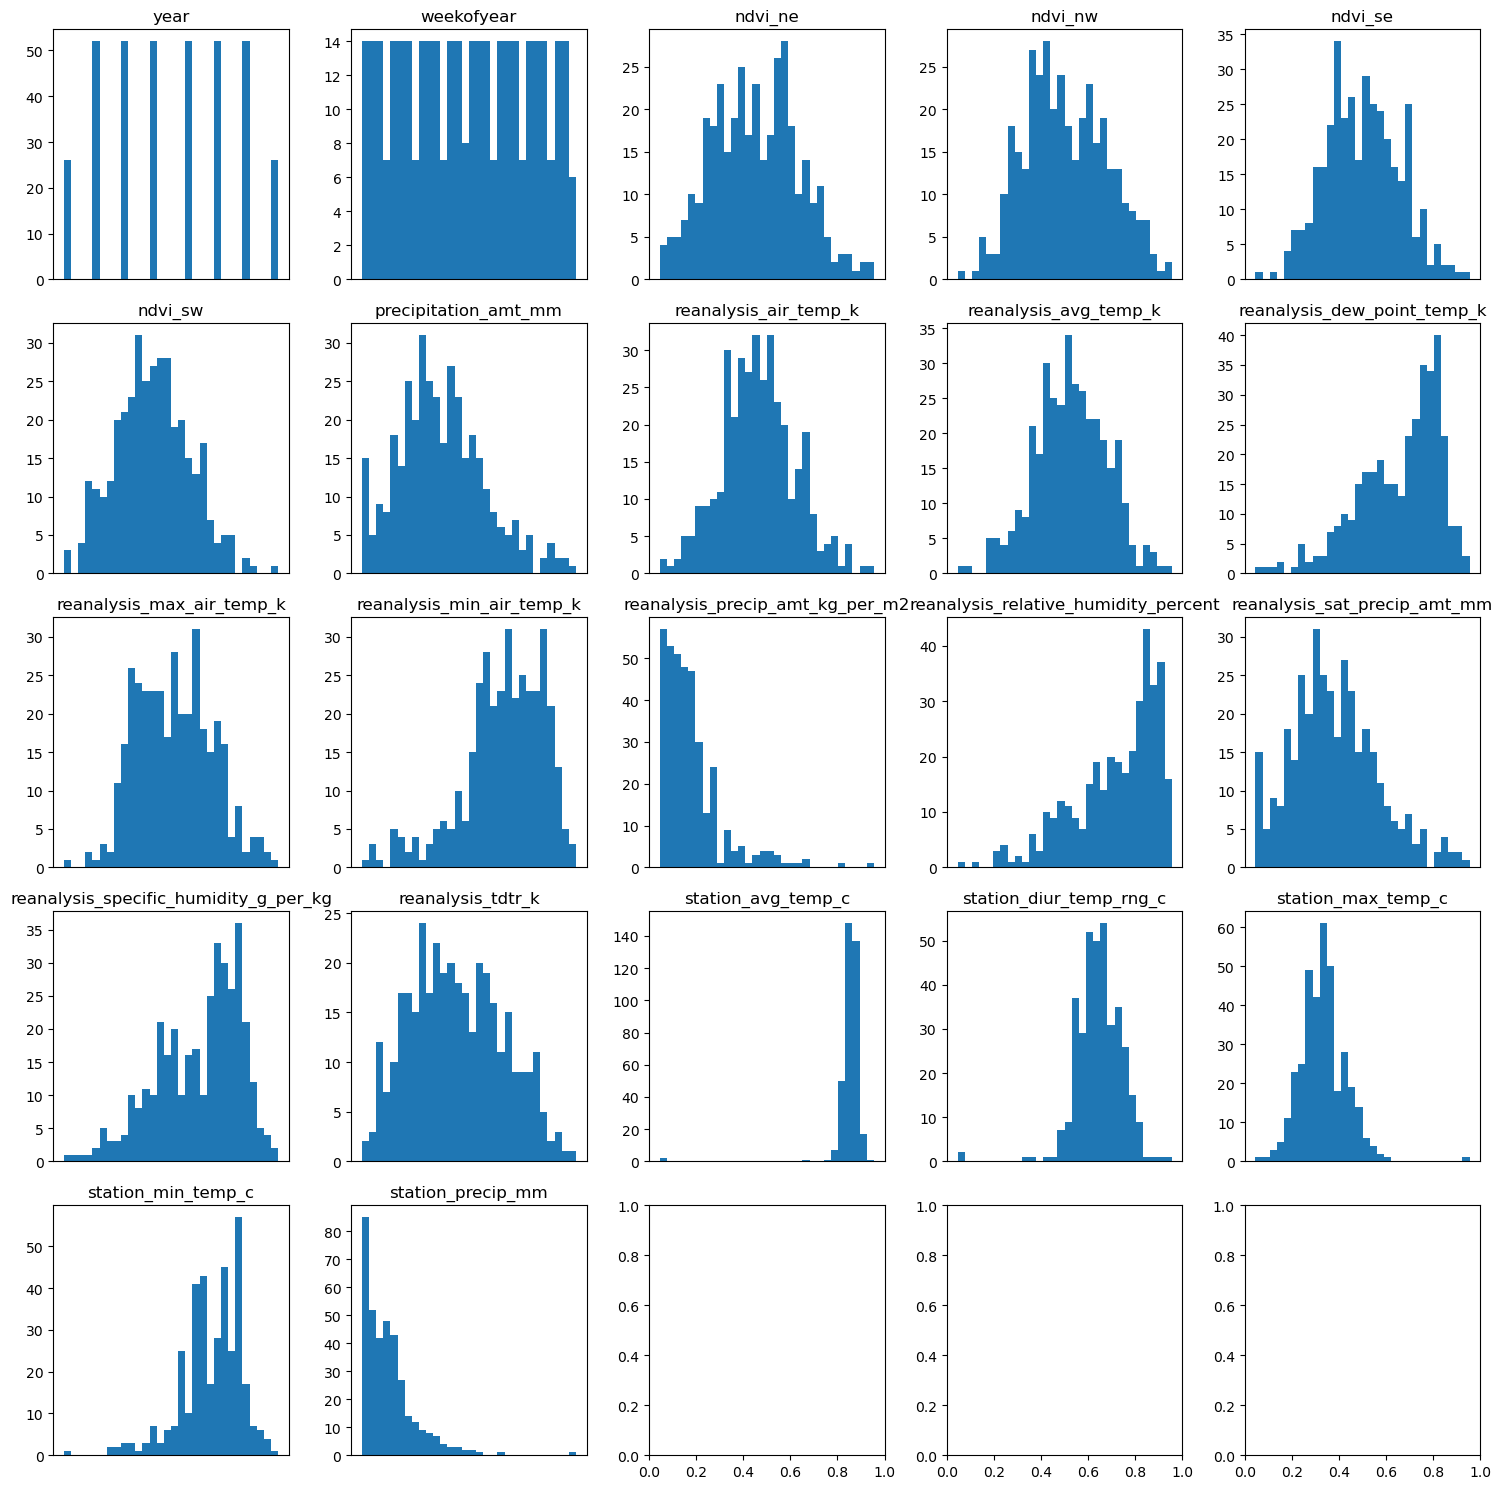

In [9]:
print(f'- Check the histograms of the variables. \n')
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
k = 0
for i in range(5):
    for j in range(5):
        axs[i,j].title.set_text(x_train.columns[k])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].hist(x_train[x_train.columns[k]], bins = 30)
        k += 1
        if k > 21:
            break
plt.tight_layout()
plt.show()

In [10]:
# Variables with skewness bigger than 2 or lower then -2
skew_df = x_train.skew().sort_values()
skew_df[skew_df.abs() > 2].index

Index(['station_avg_temp_c', 'station_precip_mm',
       'reanalysis_precip_amt_kg_per_m2'],
      dtype='object')

In [11]:
# Variables with kurtosis bigger than 7 or lower then -7
kurtosis_df = x_train.kurtosis().sort_values()
kurtosis_df[kurtosis_df.abs() > 7].index

Index(['reanalysis_precip_amt_kg_per_m2', 'station_diur_temp_rng_c',
       'station_precip_mm', 'station_avg_temp_c'],
      dtype='object')

In [12]:
for col in skew_df[skew_df.abs() > 2].index.values:
    message = f'{col} is skewed, but does not have positive or negarive enough kyrtosis!'
    if col not in kurtosis_df[kurtosis_df.abs() > 7].index.values:
        print(message)

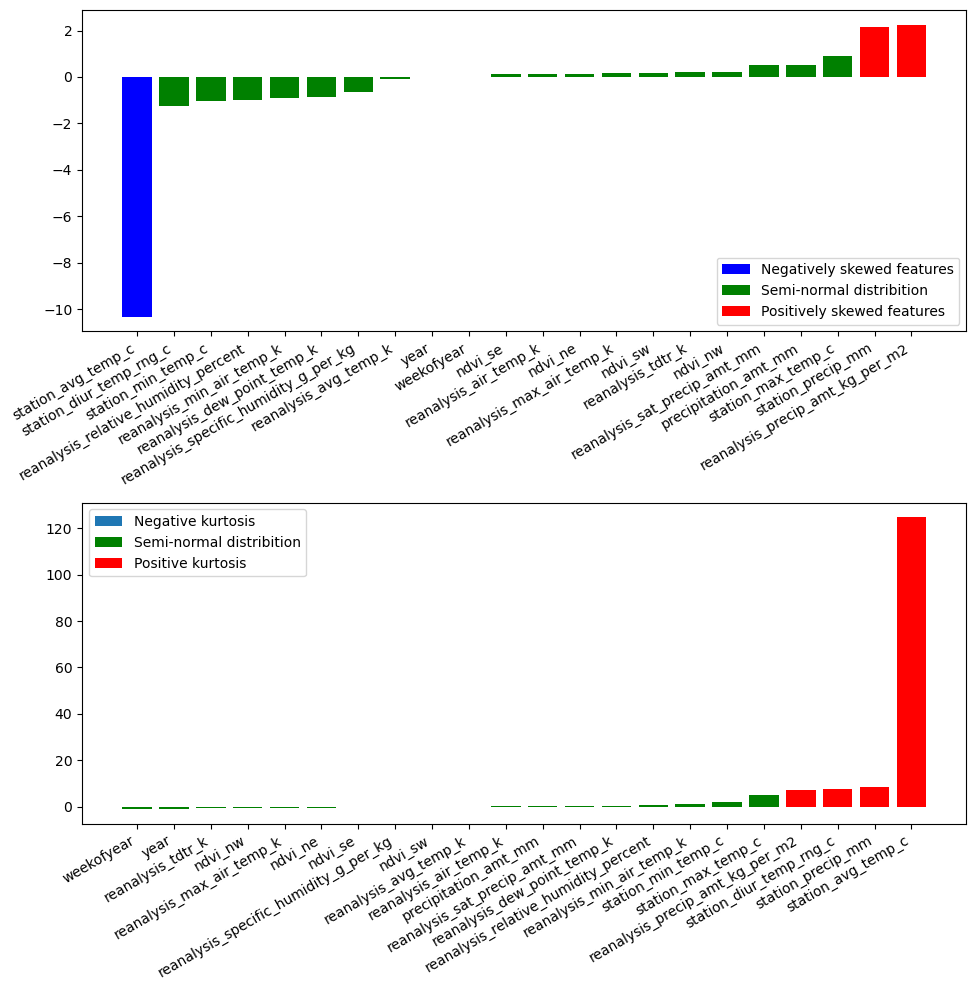

In [13]:
fig, axs = plt.subplots(2,1, figsize = (10, 10))

axs[0].bar(skew_df[skew_df < -2].index, height = skew_df[skew_df < -2], color = 'b', 
           label = 'Negatively skewed features')
axs[0].bar(x = skew_df[(skew_df < 2) & (skew_df > -2)].index, height = skew_df[(skew_df < 2) & (skew_df > -2)], 
           color = "g", label = "Semi-normal distribition")
axs[0].bar(x = skew_df[skew_df > 2].index, height = skew_df[skew_df > 2], color = 'r', 
           label = 'Positively skewed features')
axs[0].set_xticklabels(skew_df.index, rotation=30, ha='right')
axs[0].legend()

axs[1].bar(kurtosis_df[kurtosis_df < -7].index, height = kurtosis_df[kurtosis_df < -7], color = 'b', 
           label = 'Negative kurtosis')
axs[1].bar(kurtosis_df[(kurtosis_df < 7) & (kurtosis_df > -7)].index, 
           height = kurtosis_df[(kurtosis_df < 7) & (kurtosis_df > -7)], 
           color = "g", label= "Semi-normal distribition")
axs[1].bar(kurtosis_df[kurtosis_df > 7].index, height = kurtosis_df[kurtosis_df > 7], color = 'r', 
           label = 'Positive kurtosis')
axs[1].set_xticklabels(kurtosis_df.index, rotation = 30, ha='right')
axs[1].legend()

plt.tight_layout();

- ### The degree of distibution of data further for a normal distribution will affect certain model performance (specifically linear models)
- ### As such we need to try correct this feattures that have positive / negative kurtosis and skewness
- ### Investigate Transformations to create normally distributed features

In [14]:
non_dist_cols = [col for col in list(skew_df[skew_df.abs() > 2].index) and 
                 list(kurtosis_df[kurtosis_df.abs() > 7].index)]

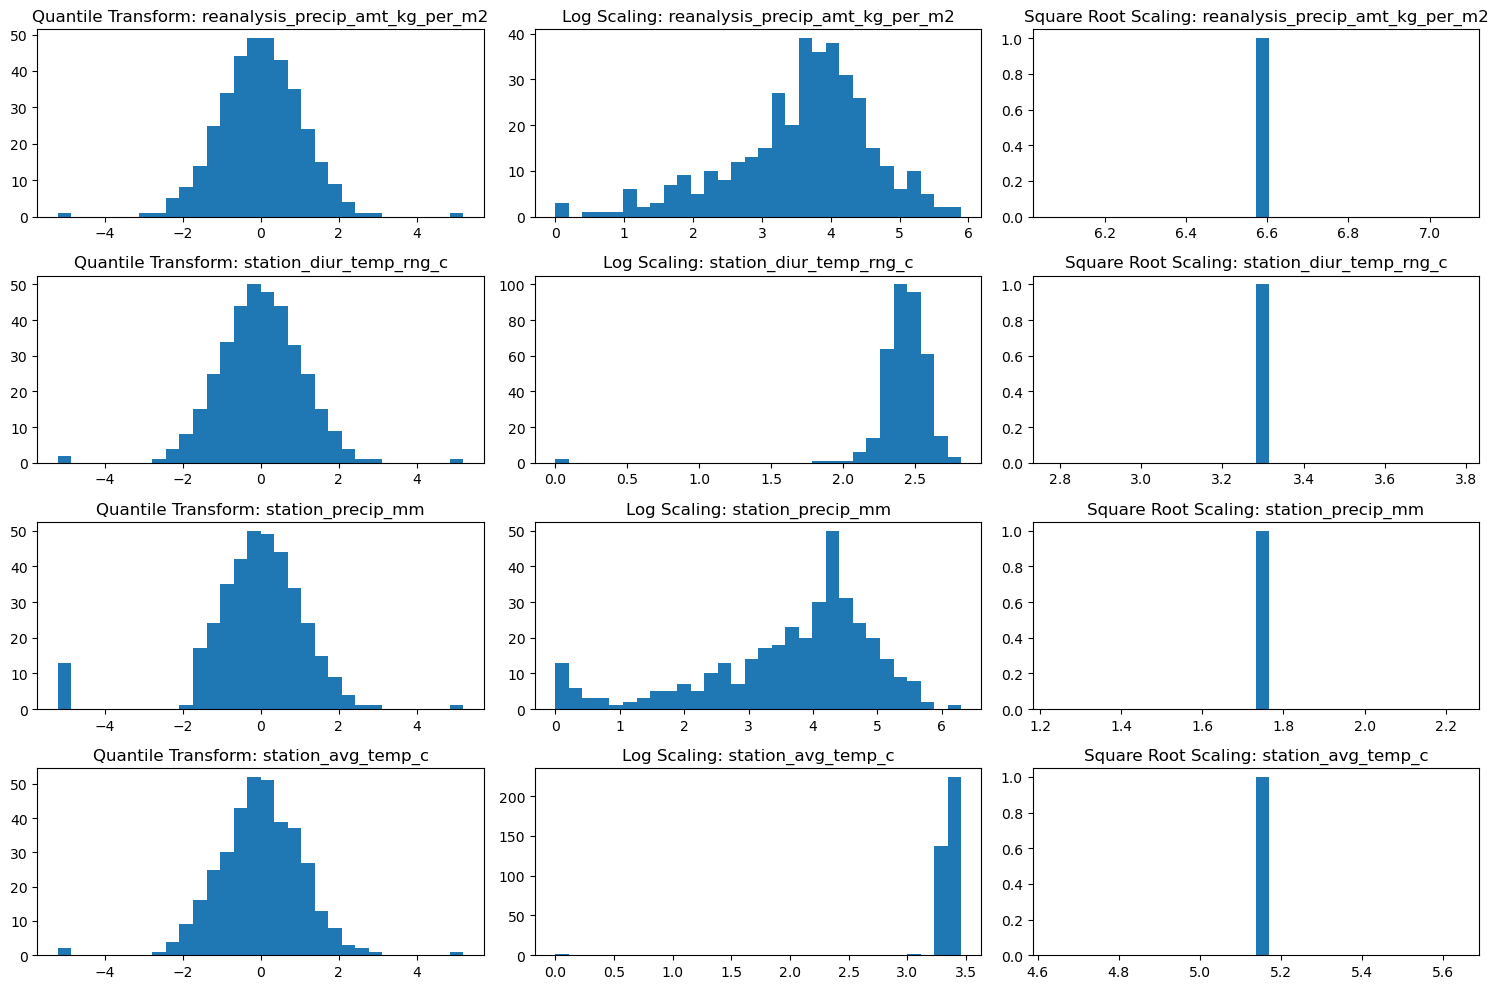

In [15]:
from sklearn.preprocessing import QuantileTransformer

fig, axs = plt.subplots(len(non_dist_cols), 3, figsize = (15,10))
for i,col in enumerate(non_dist_cols):
    q_scaler = QuantileTransformer(output_distribution="normal")
    quant_df = q_scaler.fit_transform(x_train[[col]])
    
    axs[i, 0].title.set_text('Quantile Transform: ' + col)
    axs[i, 0].hist(quant_df, bins = 30)
    
    axs[i, 1].title.set_text('Log Scaling: ' + col)
    axs[i, 1].hist(np.log1p(x_train[col]), bins = 30)
    
    axs[i, 2].title.set_text('Square Root Scaling: ' + col)
    axs[i, 2].hist(np.sqrt(x_train[col])[0], bins = 30)
    
    
plt.tight_layout();

- ### Quantile scaling might be the better choice

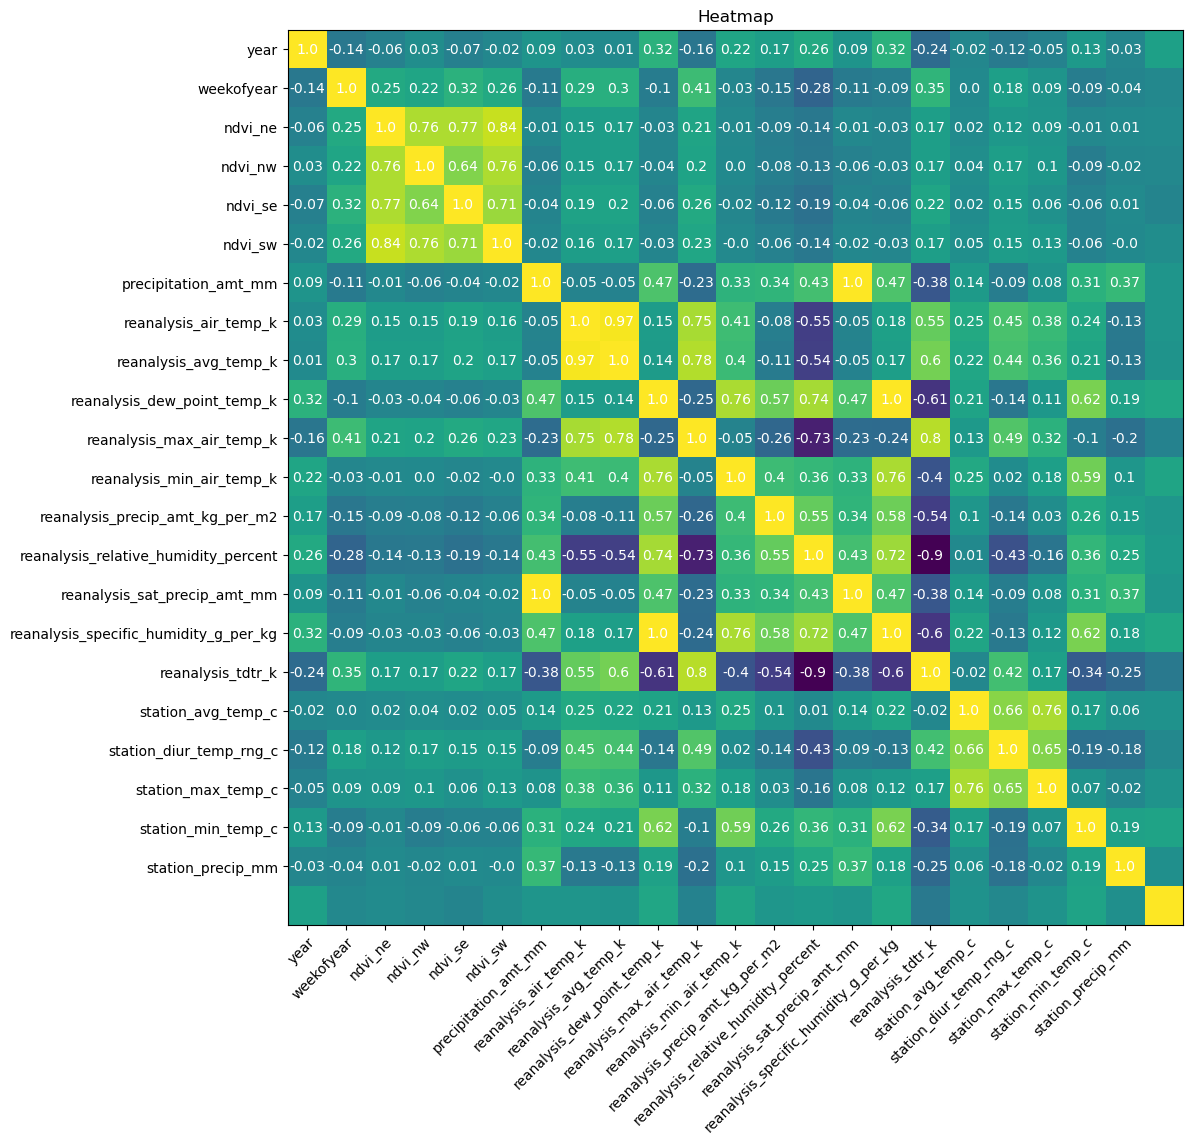

In [16]:
correlations = df.corr()
fig, ax = plt.subplots(figsize = (12, 12))
im = ax.imshow(correlations.values)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(x_train.columns)), labels = x_train.columns)
ax.set_yticks(np.arange(len(x_train.columns)), labels = x_train.columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(x_train.columns)):
    for j in range(len(x_train.columns)):
        text = ax.text(j, i, np.round(correlations.values[i, j], 2),
                       ha = "center", va = "center", color = "w")

ax.set_title("Heatmap")

fig.tight_layout()
plt.show()

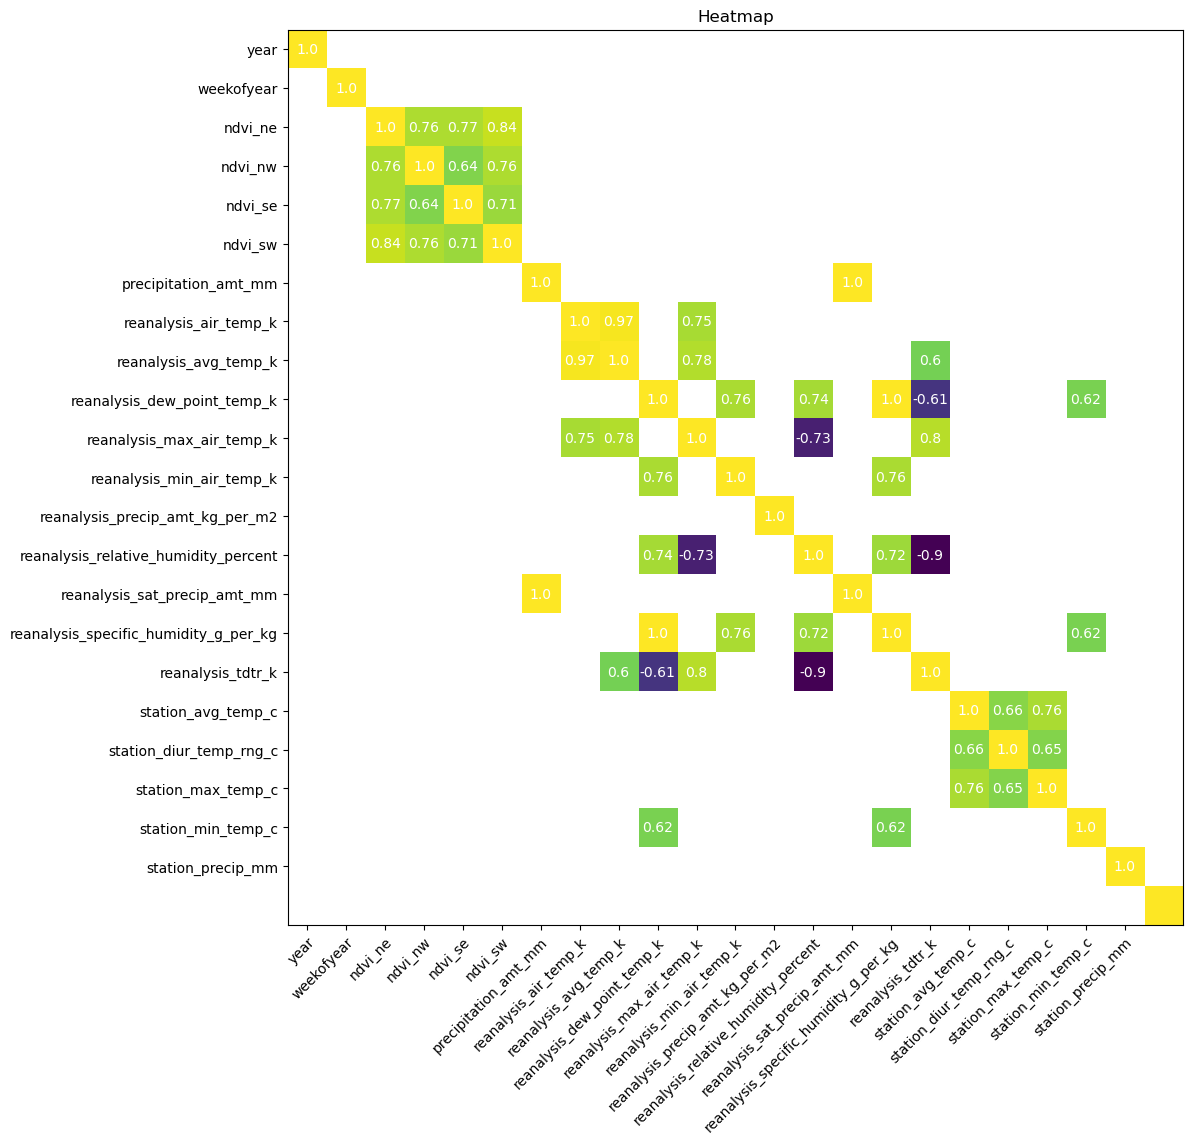

In [17]:
threshold_correlations = correlations[correlations.abs() > 0.6]
fig, ax = plt.subplots(figsize = (12, 12))
im = ax.imshow(threshold_correlations.values)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(x_train.columns)), labels = x_train.columns)
ax.set_yticks(np.arange(len(x_train.columns)), labels = x_train.columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(x_train.columns)):
    for j in range(len(x_train.columns)):
        text = ax.text(j, i, np.round(threshold_correlations.values[i, j], 2),
                       ha = "center", va = "center", color = "w")

ax.set_title("Heatmap")

fig.tight_layout()
plt.show()

In [26]:
# Highly correlated columns
# pca_cols_1 = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
#               'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_specific_humidity_g_per_kg',
#               'station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c', ]

pca_cols_1 = ['reanalysis_dew_point_temp_k', 'station_min_temp_c', 'reanalysis_tdtr_k', 
              'reanalysis_specific_humidity_g_per_kg', 'reanalysis_relative_humidity_percent',
              'reanalysis_min_air_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_avg_temp_k',
              'reanalysis_air_temp_k']
pca_cols_2 = ['ndvi_se','ndvi_sw', 'ndvi_ne', 'ndvi_nw']

- ### Linear models will be impacted negatively by correlated features, due to overfitting 
- ### Gradient boosting models will tend to overfit with highly correlated features
- ### We will use Principal Component Analysis (PCA) on highly correlated features which removes correlation

- ### Outliers will skew certain models and result in poor local optimums in trained models and reduce model performance. As such we need to assist our models in identifying outliers
- ### We will identify features with a large number of outliers through: Boxplots visualization

- Check the boxpots of the variables. 



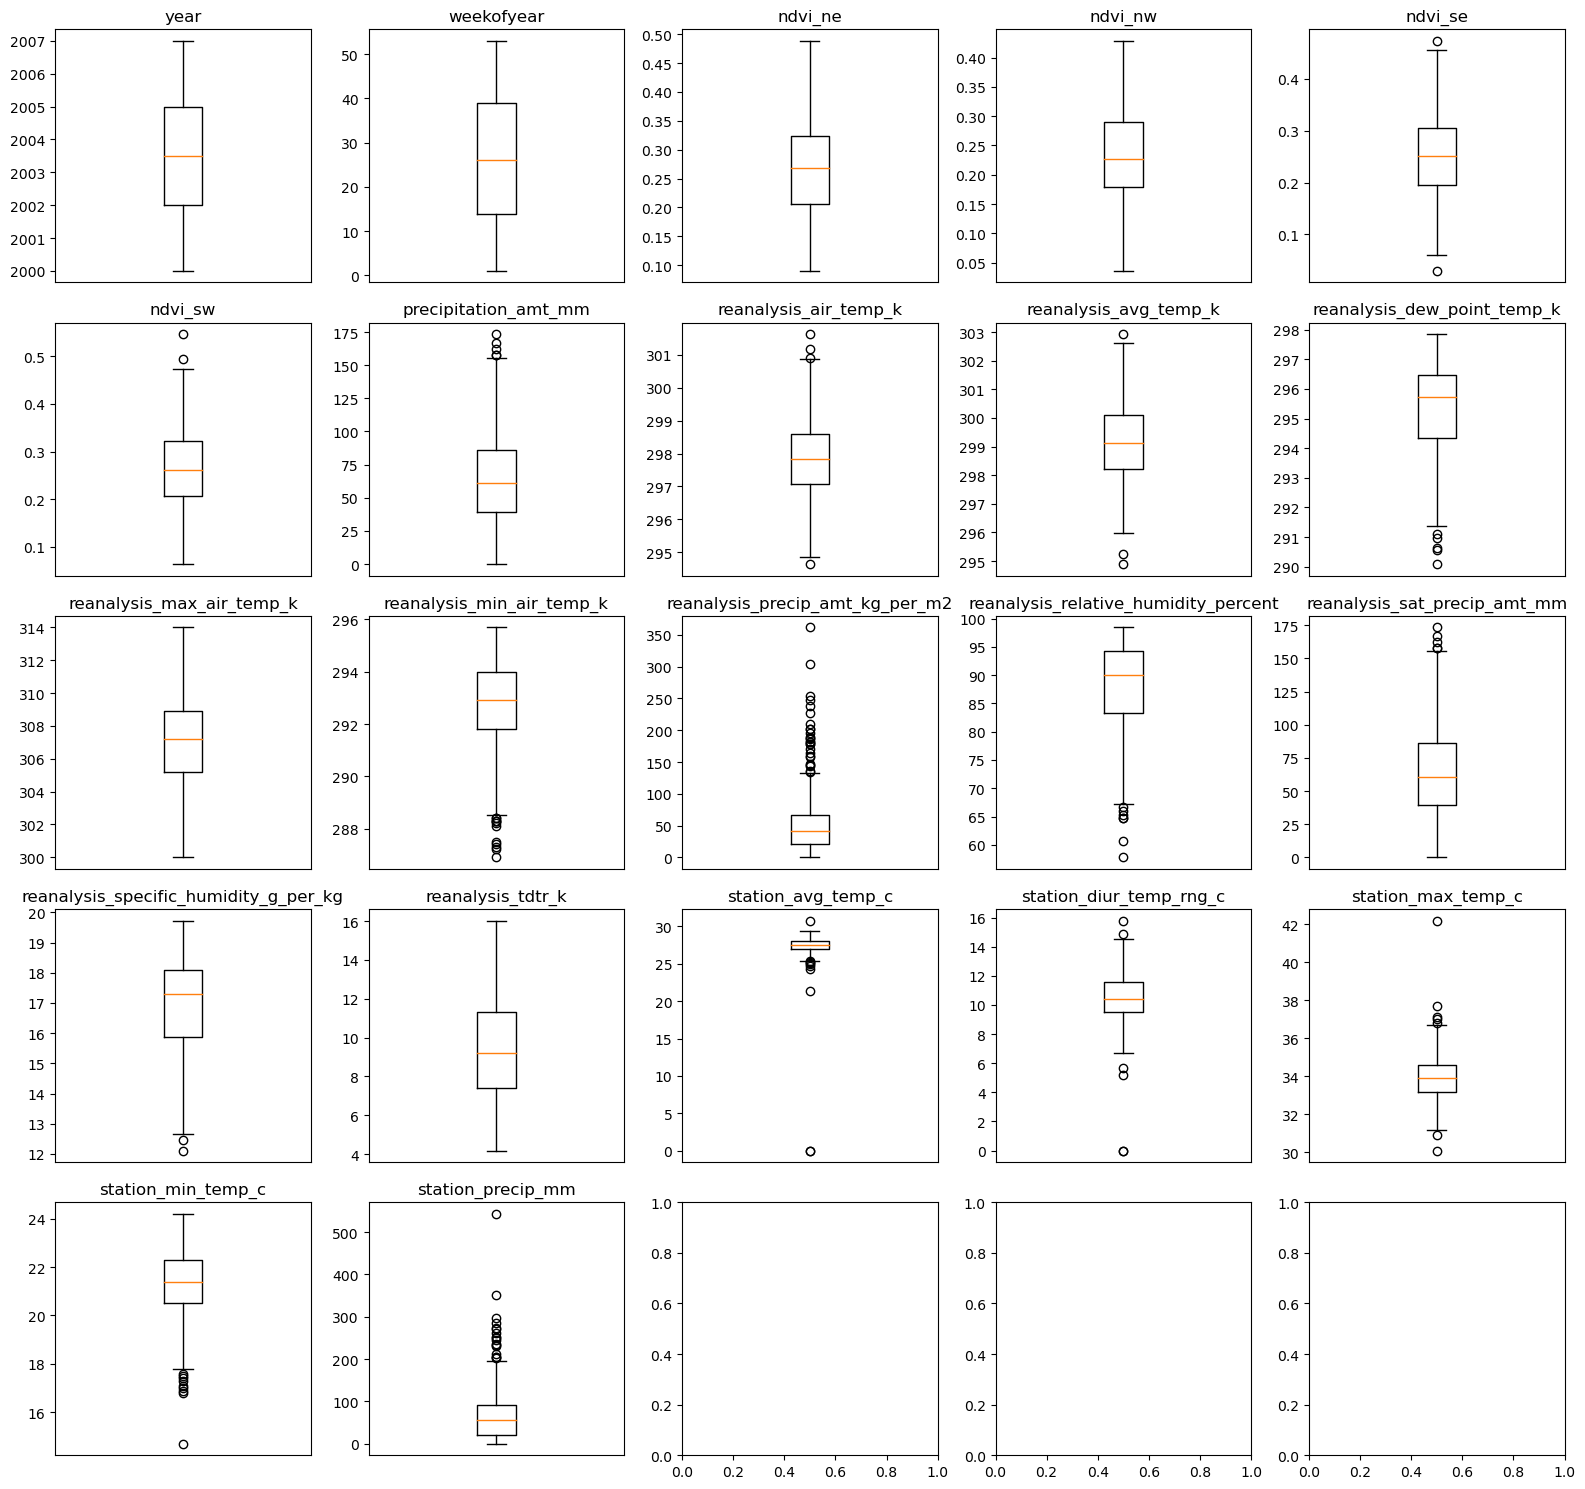

In [27]:
print(f'- Check the boxpots of the variables. \n')
fig, axs = plt.subplots(5, 5, figsize=(16, 15))
k = 0
for i in range(5):
    for j in range(5):
        try:
            axs[i,j].title.set_text(x_train.columns[k])
            axs[i,j].get_xaxis().set_visible(False)
            axs[i,j].boxplot(x_train[x_train.columns[k]])
            k += 1
        except:
            break
plt.tight_layout()
plt.show()

In [28]:
outlier_cols = ['reanalysis_precip_amt_kg_per_m2', 'station_precip_mm']

In [29]:
from sklearn.decomposition import PCA

# df_new = df
pca_t_1 = PCA(n_components = 1 ,whiten = False)
pca_t_2 = PCA(n_components = 1 ,whiten = False)
x_train["pca_1"] = pca_t_1.fit_transform(x_train[pca_cols_1])
x_train["pca_2"] = pca_t_2.fit_transform(x_train[pca_cols_2])

x_val["pca_1"] = pca_t_1.transform(x_val[pca_cols_1])
x_val["pca_2"] = pca_t_2.transform(x_val[pca_cols_2])

df_test['pca_1'] = pca_t_1.transform(df_test[pca_cols_1])
df_test['pca_2'] = pca_t_2.transform(df_test[pca_cols_2])

for col in pca_cols_1 + pca_cols_2:
    x_train.drop(col, axis = 1, inplace = True)
    x_val.drop(col, axis = 1, inplace = True)
    df_test.drop(col, axis = 1, inplace = True)

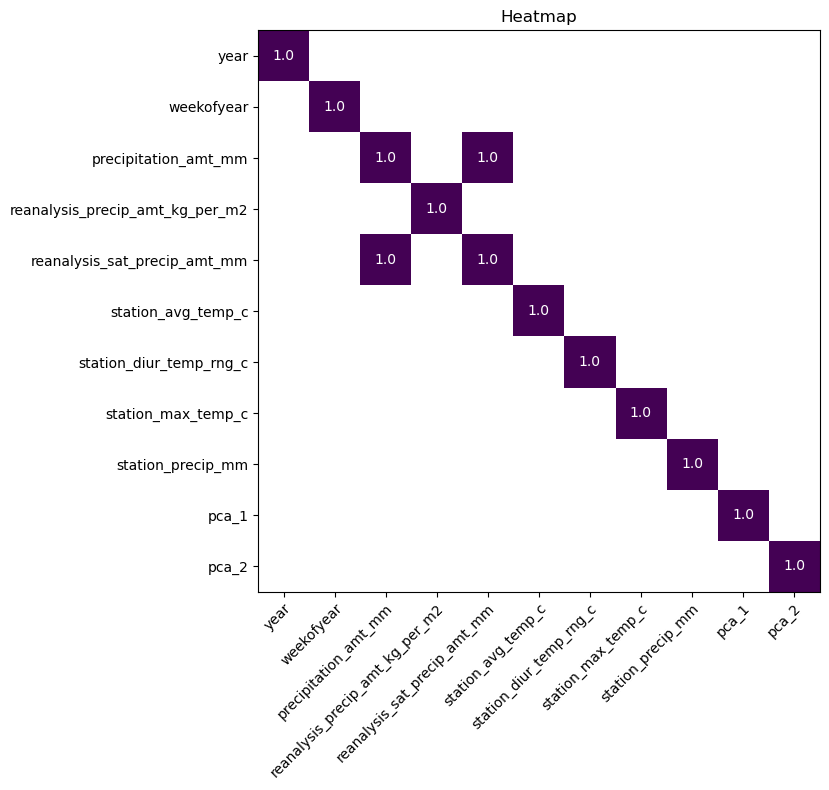

In [30]:
correlations = x_train.corr()
correlations = correlations[correlations.abs() > 0.6]
fig, ax = plt.subplots(figsize = (10, 8))
im = ax.imshow(correlations.values)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(x_train.columns)), labels = x_train.columns)
ax.set_yticks(np.arange(len(x_train.columns)), labels = x_train.columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(x_train.columns)):
    for j in range(len(x_train.columns)):
        text = ax.text(j, i, np.round(correlations.values[i, j], 2),
                       ha = "center", va = "center", color = "w")

ax.set_title("Heatmap")

fig.tight_layout()
plt.show()

- ### Most of the high correlations between variables are gone

In [31]:
non_dist_cols = [col for col in non_dist_cols if col not in pca_cols_1 + pca_cols_2]
print(non_dist_cols)

['reanalysis_precip_amt_kg_per_m2', 'station_diur_temp_rng_c', 'station_precip_mm', 'station_avg_temp_c']


- ### The above variables weren't included in the columns we used for PCA, so we will transform their distribution to approximately Normal

In [32]:
skew_1 = x_train['pca_1'].skew()
kurtosis_1 = x_train['pca_1'].kurtosis()
print(f'pca_1 feature skewness: {skew_1}')
print(f'pca_1 feature kurtosis: {kurtosis_1} \n')

skew_2 = x_train['pca_2'].skew()
kurtosis_2 = x_train['pca_2'].kurtosis()
print(f'pca_2 feature skewness: {skew_2}')
print(f'pca_2 feature kurtosis: {kurtosis_2}')

pca_1 feature skewness: 0.8796074683817067
pca_1 feature kurtosis: 0.16519686042070436 

pca_2 feature skewness: 0.11844664798065521
pca_2 feature kurtosis: -0.47009837603574667


- ### No need to transform the new features

In [33]:
for col in non_dist_cols:
    q_scaler = QuantileTransformer(output_distribution = "normal")
    x_train[col] = q_scaler.fit_transform(x_train[col].values.reshape(-1, 1))
    
    x_val[col] = q_scaler.transform(x_val[col].values.reshape(-1, 1))
    
    df_test[col] = q_scaler.transform(df_test[col].values.reshape(-1, 1))

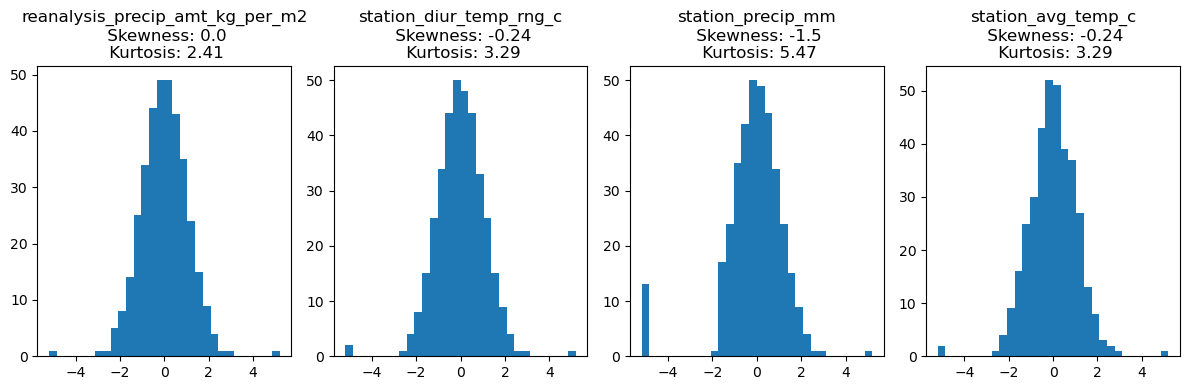

In [34]:
fig, axs = plt.subplots(1, len(non_dist_cols), figsize = (12,4))
for i,col in enumerate(non_dist_cols):
    
    axs[i].title.set_text(col + f'\n Skewness: {np.round(x_train[col].skew(), 2)}' + f'\n Kurtosis: {np.round(x_train[col].kurtosis(), 2)}')
    axs[i].hist(x_train[col], bins = 30)
    
plt.tight_layout();

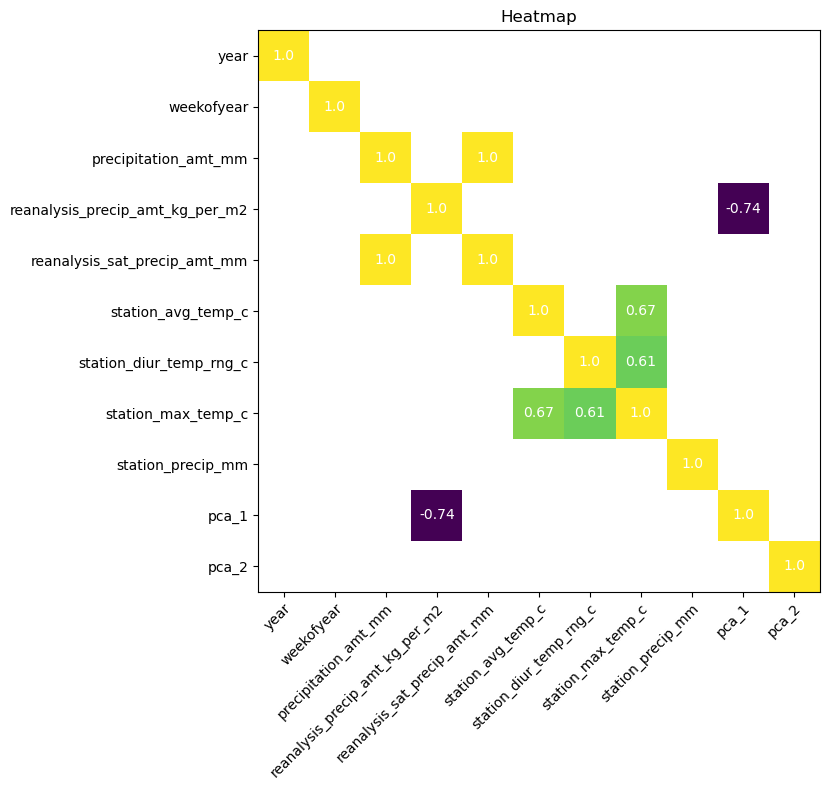

In [35]:
correlations = x_train.corr()
correlations = correlations[correlations.abs() > 0.6]
fig, ax = plt.subplots(figsize = (10, 8))
im = ax.imshow(correlations.values)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(x_train.columns)), labels = x_train.columns)
ax.set_yticks(np.arange(len(x_train.columns)), labels = x_train.columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(x_train.columns)):
    for j in range(len(x_train.columns)):
        text = ax.text(j, i, np.round(correlations.values[i, j], 2),
                       ha="center", va="center", color="w")

ax.set_title("Heatmap")

fig.tight_layout()
plt.show()

- ### The heatmap changed a little with the Quantile transformation, but we wont deal with that now

In [36]:
outlier_cols = [col for col in outlier_cols if col not in pca_cols_1 + pca_cols_2 + non_dist_cols]
print(outlier_cols)

[]


In [40]:
assert len(outlier_cols) != 0, 'No outlier columns left!'

AssertionError: No outlier columns left!

- ### If there are the cols on which we will perform Robust Scaling

In [29]:
from sklearn.preprocessing import RobustScaler

for col in outlier_cols:
    rb_scaler = RobustScaler(unit_variance = True)
    x_train[col] = rb_scaler.fit_transform(x_train[col].values.reshape(-1, 1))
    
    x_val[col] = rb_scaler.transform(x_val[col].values.reshape(-1, 1))
    
    df_test[col] = rb_scaler.transform(df_test[col].values.reshape(-1, 1))

- Check the boxpots of the variables again. 



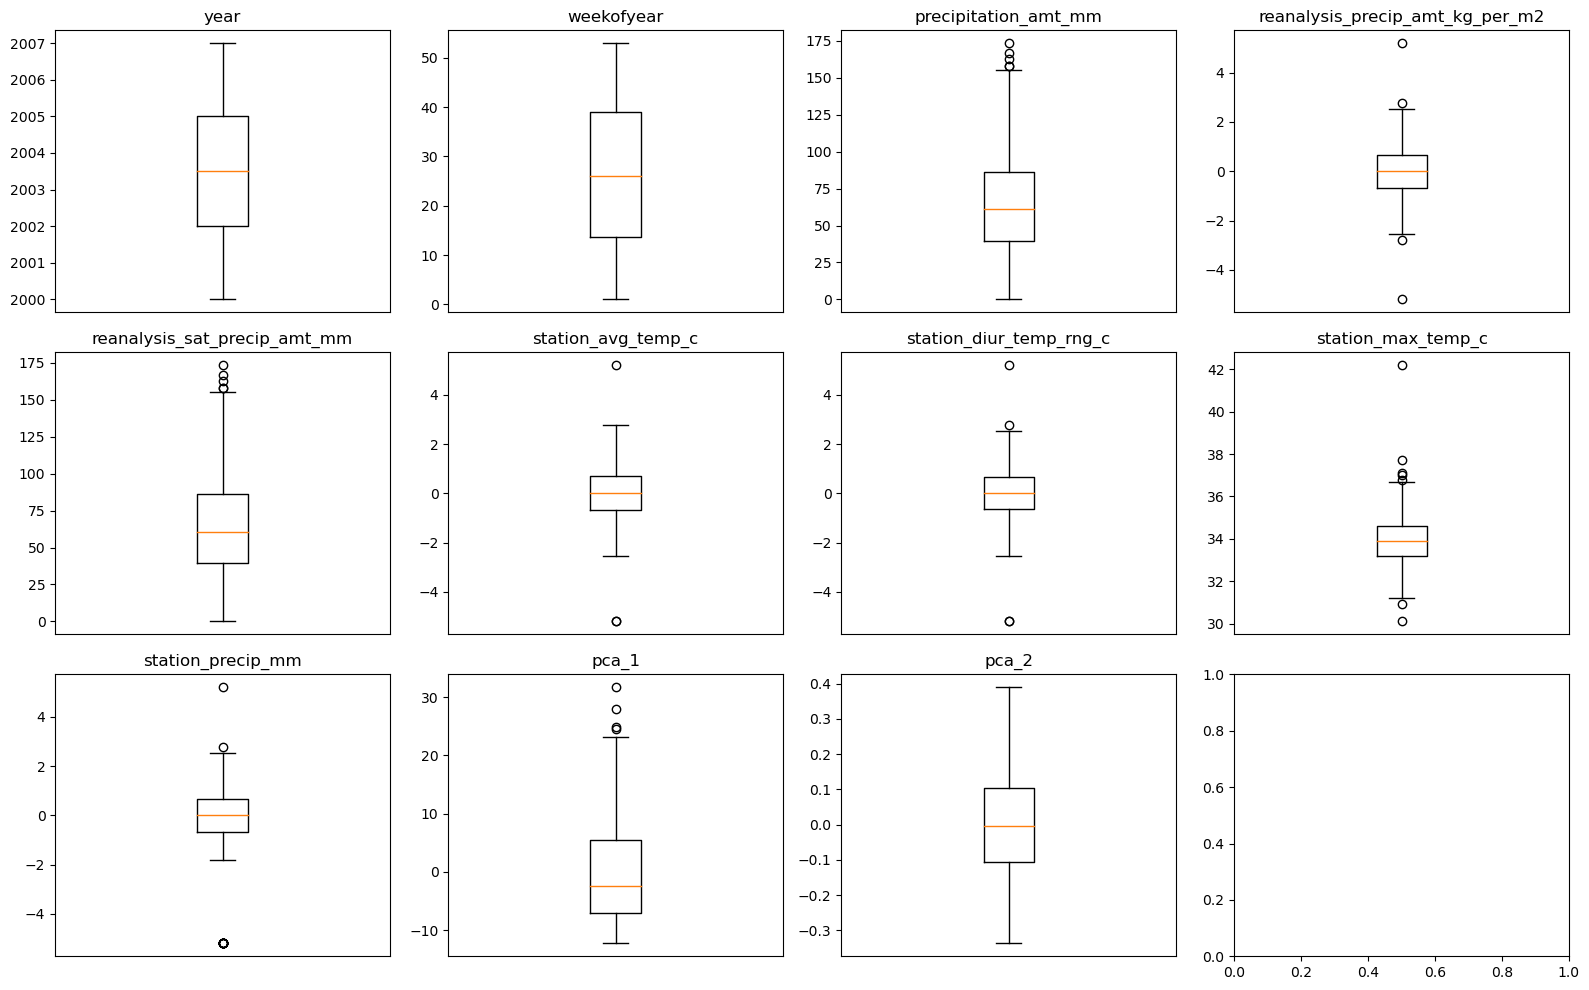

In [41]:
print(f'- Check the boxpots of the variables again. \n')
fig, axs = plt.subplots(3, 4, figsize=(16, 10))
k = 0
for i in range(3):
    for j in range(4):
        try:
            axs[i,j].title.set_text(x_train.columns[k])
            axs[i,j].get_xaxis().set_visible(False)
            axs[i,j].boxplot(x_train[x_train.columns[k]])
            k += 1
        except:
            break

plt.tight_layout()
plt.show()

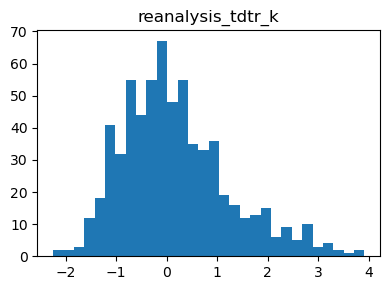

In [31]:
fig, axs = plt.subplots(1, len(outlier_cols), figsize = (4,3))
for i,col in enumerate(outlier_cols):
    if len(outlier_cols) == 1:
        axs.title.set_text(col)
        axs.hist(x_train[col], bins = 30)
    else:
        axs[i].title.set_text(col)
        axs[i].hist(x_train[col], bins = 30)
    
plt.tight_layout();

In [43]:
x_train.to_csv('Data/x_train.csv')
x_val.to_csv('Data/x_val.csv')

y_train.to_csv('Data/y_train.csv')
y_val.to_csv('Data/y_val.csv')

df_test.to_csv('Data/modified_test_data.csv')